#### Download data from Kaggle

In [2]:
from kaggle_utils.src import KaggleDataApi

In [3]:
kda = KaggleDataApi(call_path = CURRENT_ROOT_DIR)
kda.download_kaggle_dataset(dataset_name="facial_keypoints_detection")

File downloaded and saved to:   c:\users\sankr\documents\projects\git_work\experiments\data\facial-keypoints-detection.zip


In [4]:
kda.unzip_and_return_folder_details()

('c:\\users\\sankr\\documents\\projects\\git_work\\experiments\\data\\facial-keypoints-detection',
 ['IdLookupTable.csv', 'SampleSubmission.csv', 'test.zip', 'training.zip'])

In [7]:
for file_name in ["test.zip", "training.zip"]:
    complete_path = os.path.join(root_folder, file_name)
    with zipfile.ZipFile(complete_path, 'r') as zip_ref:
        zip_ref.extractall(root_folder)

#### Pre-process test and train images to store as images and annotation

In [1]:
root_folder = "c:\\users\\sankr\\documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoints-detection"
import os
import zipfile
import pandas as pd
import numpy as np

In [2]:
os.listdir(root_folder)

['IdLookupTable.csv',
 'models',
 'SampleSubmission.csv',
 'submissions',
 'test.csv',
 'test.zip',
 'training.csv',
 'training.zip']

In [3]:
annotation_file = os.path.join(root_folder, "IdLookupTable.csv")
submission_file = os.path.join(root_folder, "SampleSubmission.csv")
test_data = os.path.join(root_folder, "test.csv")
train_data = os.path.join(root_folder, "training.csv")

In [4]:
os.makedirs(os.path.join(root_folder, train_data.replace("csv", "")), exist_ok =True)
os.makedirs(os.path.join(root_folder, test_data.replace("csv", "")), exist_ok = True)

In [5]:
from PIL import Image

In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv(train_data)

In [8]:
df["Image"] = df.Image.apply(lambda x: np.array(x.split(" "), dtype="float"))


In [9]:
df.Image[0].shape

(9216,)

In [10]:
df["Image"] = df.Image.apply(lambda pixel: pixel.reshape(96, 96, 1))
df["Image"] = df.Image.apply(lambda pixel: pixel/255)
images = df.pop("Image")

In [11]:
df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [12]:
images[0]

array([[[0.93333333],
        [0.9254902 ],
        [0.92941176],
        ...,
        [0.98039216],
        [0.98039216],
        [0.98039216]],

       [[0.92156863],
        [0.93333333],
        [0.9254902 ],
        ...,
        [0.97647059],
        [0.98039216],
        [0.98431373]],

       [[0.92941176],
        [0.9254902 ],
        [0.92941176],
        ...,
        [0.98431373],
        [0.98431373],
        [0.98039216]],

       ...,

       [[0.72941176],
        [0.71764706],
        [0.70980392],
        ...,
        [0.20392157],
        [0.22352941],
        [0.23529412]],

       [[0.74117647],
        [0.7372549 ],
        [0.81176471],
        ...,
        [0.23921569],
        [0.27058824],
        [0.30588235]],

       [[0.74901961],
        [0.72156863],
        [0.72156863],
        ...,
        [0.2745098 ],
        [0.29411765],
        [0.35294118]]])

In [13]:
isinstance(images[0], np.ndarray)

True

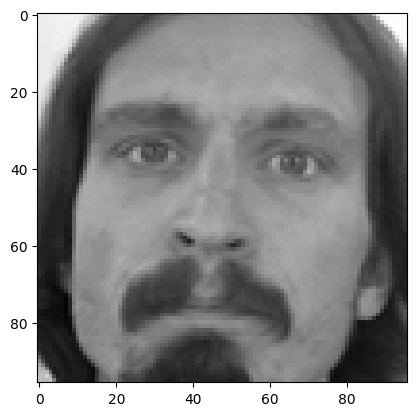

In [14]:
from matplotlib import pyplot as plt

plt.imshow(images[0], cmap="gray")

In [15]:
images[0].shape

(96, 96, 1)

#### Modelling

In [3]:
from src.cv.pytorch.datasets.facial_keypoint_detection.dataset import FacialKeypointDataset
from src.cv.model_pipelines.facial_keypoint_cnn_pipeline import FacialCNNTrainingPipeline

In [4]:
fkd = FacialKeypointDataset(
    dataset_name="faces", 
    data_type = "csv",
    data_file=r"data/facial-keypoints-detection/training.csv",
    resize_size=96,
    is_test=False
)


In [5]:
len(fkd)

7049

In [8]:
from src.cv.pytorch.datasets.facial_keypoint_detection.utils import multi_view_image_keypoints, show_key_points_on_images

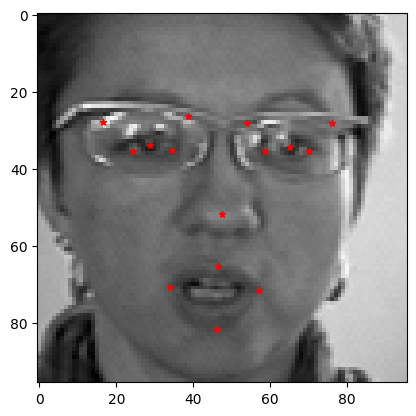

In [9]:
show_key_points_on_images(dataset=fkd, idx=10)

In [10]:
data = [fkd[i] for i in range(9)]

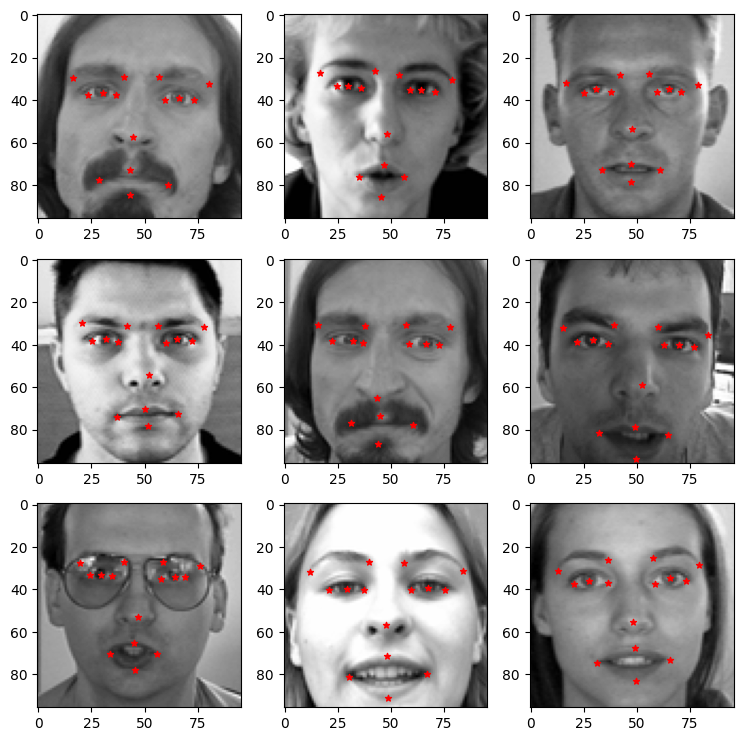

In [11]:
multi_view_image_keypoints(data=data)

#### V1 - Basecase

In [12]:
# Initial config for training
model_training_config = dict(
    learning_rate=0.05,
    batch_size=250,
    epochs=50,
    batch_norm_momentum=0.5
)
model_data_config = dict(
     dataset_size=len(fkd), train_data_pct=0.8, model_save_path="C:\\Users\\sankr\\Documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoint-detection"
)

In [13]:
model_initialization_params=dict(
    cnn_layers = 3,
    input_channel = 1,
    output_channels = [32, 64, 96, 128, 30],
    kernel_sizes = [(5,5), (3,3), (3,3)],
    linear_layers = 2,
    dropout_addition_options=5, 
    dropout_threshold=0.2,
    cnn_batch_norm_flag = True
)

In [16]:
facial_keypoint_pipeline = FacialCNNTrainingPipeline(
    dataset=fkd,
    model_data_config=model_data_config,
    model_initialization_params=model_initialization_params,
    model_training_config = model_training_config,
)

In [17]:
print(facial_keypoint_pipeline.model)

FacialKeypointVCNN(
  (maxPool2d1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (conv2d1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (maxPool2d2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (conv2d2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (maxPool2d3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (conv2d3): Sequential(
 

In [18]:
facial_keypoint_pipeline.train()

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

root - INFO - Train Loss for epoch 0: 1961.5427 - 06-Feb-23 23:52:36
root - INFO - Validation Loss for epoch 0: 110.3251 - 06-Feb-23 23:53:24


  2%|█▌                                                                               | 1/50 [01:31<1:15:06, 91.96s/it]

root - INFO - Train Loss for epoch 1: 51.0379 - 06-Feb-23 23:54:03
root - INFO - Validation Loss for epoch 1: 29.5495 - 06-Feb-23 23:54:34


  4%|███▏                                                                             | 2/50 [02:41<1:03:06, 78.89s/it]

root - INFO - Train Loss for epoch 2: 25.5373 - 06-Feb-23 23:55:02
root - INFO - Validation Loss for epoch 2: 18.2967 - 06-Feb-23 23:55:29


  6%|████▉                                                                              | 3/50 [03:36<53:17, 68.04s/it]

root - INFO - Train Loss for epoch 3: 19.8732 - 06-Feb-23 23:55:58
root - INFO - Validation Loss for epoch 3: 15.1073 - 06-Feb-23 23:56:30


  8%|██████▋                                                                            | 4/50 [04:38<50:10, 65.44s/it]

root - INFO - Train Loss for epoch 4: 17.7928 - 06-Feb-23 23:57:00
root - INFO - Validation Loss for epoch 4: 13.7522 - 06-Feb-23 23:57:32


 10%|████████▎                                                                          | 5/50 [05:40<48:11, 64.25s/it]

root - INFO - Train Loss for epoch 5: 16.9237 - 06-Feb-23 23:58:10
root - INFO - Validation Loss for epoch 5: 12.9256 - 06-Feb-23 23:58:48


 12%|█████████▉                                                                         | 6/50 [06:55<49:53, 68.03s/it]

root - INFO - Train Loss for epoch 6: 16.8333 - 06-Feb-23 23:59:30
root - INFO - Validation Loss for epoch 6: 12.8305 - 07-Feb-23 00:00:17


 14%|███████████▌                                                                       | 7/50 [08:24<53:36, 74.80s/it]

root - INFO - Train Loss for epoch 7: 16.1907 - 07-Feb-23 00:01:03
root - INFO - Validation Loss for epoch 7: 12.9154 - 07-Feb-23 00:01:53


 16%|█████████████▎                                                                     | 8/50 [10:01<57:17, 81.83s/it]

root - INFO - Train Loss for epoch 8: 15.6202 - 07-Feb-23 00:02:40
root - INFO - Validation Loss for epoch 8: 14.3970 - 07-Feb-23 00:03:27


 18%|██████████████▉                                                                    | 9/50 [11:34<58:20, 85.37s/it]

root - INFO - Train Loss for epoch 9: 15.4096 - 07-Feb-23 00:04:13
root - INFO - Validation Loss for epoch 9: 13.5404 - 07-Feb-23 00:05:01


 20%|████████████████▍                                                                 | 10/50 [13:08<58:41, 88.04s/it]

root - INFO - Train Loss for epoch 10: 16.0473 - 07-Feb-23 00:05:48
root - INFO - Validation Loss for epoch 10: 13.6224 - 07-Feb-23 00:06:33


 22%|██████████████████                                                                | 11/50 [14:40<58:01, 89.26s/it]

root - INFO - Train Loss for epoch 11: 15.8122 - 07-Feb-23 00:07:20
root - INFO - Validation Loss for epoch 11: 13.3209 - 07-Feb-23 00:08:08


 24%|███████████████████▋                                                              | 12/50 [16:16<57:47, 91.26s/it]

root - INFO - Train Loss for epoch 12: 14.2743 - 07-Feb-23 00:08:56
root - INFO - Validation Loss for epoch 12: 12.0558 - 07-Feb-23 00:09:49


 26%|█████████████████████▎                                                            | 13/50 [17:56<57:56, 93.95s/it]

root - INFO - Train Loss for epoch 13: 14.4250 - 07-Feb-23 00:10:45
root - INFO - Validation Loss for epoch 13: 12.1879 - 07-Feb-23 00:11:39


 28%|██████████████████████▉                                                           | 14/50 [19:47<59:24, 99.01s/it]

root - INFO - Train Loss for epoch 14: 13.7259 - 07-Feb-23 00:12:30
root - INFO - Validation Loss for epoch 14: 11.4115 - 07-Feb-23 00:13:15


 30%|████████████████████████▌                                                         | 15/50 [21:23<57:13, 98.10s/it]

root - INFO - Train Loss for epoch 15: 13.8177 - 07-Feb-23 00:14:00
root - INFO - Validation Loss for epoch 15: 11.5134 - 07-Feb-23 00:14:43


 32%|██████████████████████████▏                                                       | 16/50 [22:51<53:52, 95.07s/it]

root - INFO - Train Loss for epoch 16: 13.6884 - 07-Feb-23 00:15:25
root - INFO - Validation Loss for epoch 16: 11.4757 - 07-Feb-23 00:16:05


 34%|███████████████████████████▉                                                      | 17/50 [24:12<50:03, 91.02s/it]

root - INFO - Train Loss for epoch 17: 13.4029 - 07-Feb-23 00:16:50
root - INFO - Validation Loss for epoch 17: 11.9441 - 07-Feb-23 00:17:33


 36%|█████████████████████████████▌                                                    | 18/50 [25:40<48:01, 90.06s/it]

root - INFO - Train Loss for epoch 18: 13.2857 - 07-Feb-23 00:18:18
root - INFO - Validation Loss for epoch 18: 11.4126 - 07-Feb-23 00:18:58


 38%|███████████████████████████████▏                                                  | 19/50 [27:05<45:45, 88.56s/it]

root - INFO - Train Loss for epoch 19: 13.8170 - 07-Feb-23 00:19:43
root - INFO - Validation Loss for epoch 19: 12.6575 - 07-Feb-23 00:20:28


 40%|████████████████████████████████▊                                                 | 20/50 [28:36<44:35, 89.17s/it]

root - INFO - Train Loss for epoch 20: 14.2624 - 07-Feb-23 00:21:19
root - INFO - Validation Loss for epoch 20: 11.6814 - 07-Feb-23 00:22:09


 42%|██████████████████████████████████▍                                               | 21/50 [30:17<44:49, 92.74s/it]

root - INFO - Train Loss for epoch 21: 13.2803 - 07-Feb-23 00:23:03
root - INFO - Validation Loss for epoch 21: 11.8823 - 07-Feb-23 00:23:56


 44%|████████████████████████████████████                                              | 22/50 [32:04<45:13, 96.93s/it]

root - INFO - Train Loss for epoch 22: 13.7811 - 07-Feb-23 00:24:50
root - INFO - Validation Loss for epoch 22: 11.5466 - 07-Feb-23 00:25:38


 46%|█████████████████████████████████████▋                                            | 23/50 [33:45<44:15, 98.37s/it]

root - INFO - Train Loss for epoch 23: 12.8992 - 07-Feb-23 00:26:31
root - INFO - Validation Loss for epoch 23: 11.3730 - 07-Feb-23 00:27:23


 48%|██████████████████████████████████████▉                                          | 24/50 [35:31<43:32, 100.49s/it]

root - INFO - Train Loss for epoch 24: 12.9232 - 07-Feb-23 00:28:18
root - INFO - Validation Loss for epoch 24: 11.5298 - 07-Feb-23 00:29:09


 50%|████████████████████████████████████████▌                                        | 25/50 [37:17<42:34, 102.19s/it]

root - INFO - Train Loss for epoch 25: 13.2823 - 07-Feb-23 00:30:02
root - INFO - Validation Loss for epoch 25: 13.0297 - 07-Feb-23 00:30:54


 52%|██████████████████████████████████████████                                       | 26/50 [39:01<41:07, 102.81s/it]

root - INFO - Train Loss for epoch 26: 13.9190 - 07-Feb-23 00:31:46
root - INFO - Validation Loss for epoch 26: 13.0432 - 07-Feb-23 00:32:36


 54%|███████████████████████████████████████████▋                                     | 27/50 [40:43<39:19, 102.57s/it]

root - INFO - Train Loss for epoch 27: 12.9930 - 07-Feb-23 00:33:22
root - INFO - Validation Loss for epoch 27: 11.3665 - 07-Feb-23 00:34:01


 56%|█████████████████████████████████████████████▉                                    | 28/50 [42:08<35:39, 97.25s/it]

root - INFO - Train Loss for epoch 28: 13.0812 - 07-Feb-23 00:34:48
root - INFO - Validation Loss for epoch 28: 11.1675 - 07-Feb-23 00:35:29


 58%|███████████████████████████████████████████████▌                                  | 29/50 [43:37<33:07, 94.62s/it]

root - INFO - Train Loss for epoch 29: 12.9012 - 07-Feb-23 00:36:15
root - INFO - Validation Loss for epoch 29: 11.1088 - 07-Feb-23 00:36:55


 60%|█████████████████████████████████████████████████▏                                | 30/50 [45:03<30:41, 92.06s/it]

root - INFO - Train Loss for epoch 30: 12.4264 - 07-Feb-23 00:37:38
root - INFO - Validation Loss for epoch 30: 11.0746 - 07-Feb-23 00:38:20


 62%|██████████████████████████████████████████████████▊                               | 31/50 [46:28<28:28, 89.92s/it]

root - INFO - Train Loss for epoch 31: 12.3012 - 07-Feb-23 00:39:04
root - INFO - Validation Loss for epoch 31: 12.7702 - 07-Feb-23 00:39:43


 64%|████████████████████████████████████████████████████▍                             | 32/50 [47:51<26:23, 87.95s/it]

root - INFO - Train Loss for epoch 32: 12.9499 - 07-Feb-23 00:40:26
root - INFO - Validation Loss for epoch 32: 11.9571 - 07-Feb-23 00:41:07


 66%|██████████████████████████████████████████████████████                            | 33/50 [49:15<24:33, 86.68s/it]

root - INFO - Train Loss for epoch 33: 12.4764 - 07-Feb-23 00:41:49
root - INFO - Validation Loss for epoch 33: 10.9948 - 07-Feb-23 00:42:32


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [50:39<22:56, 86.02s/it]

root - INFO - Train Loss for epoch 34: 12.3837 - 07-Feb-23 00:43:26
root - INFO - Validation Loss for epoch 34: 10.8949 - 07-Feb-23 00:44:15


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [52:23<22:49, 91.30s/it]

root - INFO - Train Loss for epoch 35: 12.9012 - 07-Feb-23 00:45:07
root - INFO - Validation Loss for epoch 35: 14.1851 - 07-Feb-23 00:45:56


 72%|███████████████████████████████████████████████████████████                       | 36/50 [54:03<21:57, 94.12s/it]

root - INFO - Train Loss for epoch 36: 12.7355 - 07-Feb-23 00:46:42
root - INFO - Validation Loss for epoch 36: 11.1156 - 07-Feb-23 00:47:24


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [55:32<20:00, 92.35s/it]

root - INFO - Train Loss for epoch 37: 12.0728 - 07-Feb-23 00:48:08
root - INFO - Validation Loss for epoch 37: 11.3040 - 07-Feb-23 00:48:46


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [56:53<17:49, 89.16s/it]

root - INFO - Train Loss for epoch 38: 12.0189 - 07-Feb-23 00:49:25
root - INFO - Validation Loss for epoch 38: 10.9134 - 07-Feb-23 00:50:16


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [58:23<16:22, 89.34s/it]

root - INFO - Train Loss for epoch 39: 12.6879 - 07-Feb-23 00:51:05
root - INFO - Validation Loss for epoch 39: 11.8985 - 07-Feb-23 00:51:53


 80%|████████████████████████████████████████████████████████████████                | 40/50 [1:00:00<15:16, 91.62s/it]

root - INFO - Train Loss for epoch 40: 12.0283 - 07-Feb-23 00:52:44
root - INFO - Validation Loss for epoch 40: 10.9232 - 07-Feb-23 00:53:33


 82%|█████████████████████████████████████████████████████████████████▌              | 41/50 [1:01:40<14:07, 94.20s/it]

root - INFO - Train Loss for epoch 41: 12.0352 - 07-Feb-23 00:54:21
root - INFO - Validation Loss for epoch 41: 10.9228 - 07-Feb-23 00:55:09


 84%|███████████████████████████████████████████████████████████████████▏            | 42/50 [1:03:17<12:39, 94.88s/it]

root - INFO - Train Loss for epoch 42: 11.7171 - 07-Feb-23 00:55:59
root - INFO - Validation Loss for epoch 42: 11.4705 - 07-Feb-23 00:56:46


 86%|████████████████████████████████████████████████████████████████████▊           | 43/50 [1:04:54<11:08, 95.47s/it]

root - INFO - Train Loss for epoch 43: 12.1028 - 07-Feb-23 00:57:34
root - INFO - Validation Loss for epoch 43: 10.9423 - 07-Feb-23 00:58:25


 88%|██████████████████████████████████████████████████████████████████████▍         | 44/50 [1:06:32<09:38, 96.37s/it]

root - INFO - Train Loss for epoch 44: 12.3152 - 07-Feb-23 00:59:19
root - INFO - Validation Loss for epoch 44: 11.7525 - 07-Feb-23 01:00:08


 90%|████████████████████████████████████████████████████████████████████████        | 45/50 [1:08:16<08:12, 98.59s/it]

root - INFO - Train Loss for epoch 45: 12.1357 - 07-Feb-23 01:00:56
root - INFO - Validation Loss for epoch 45: 11.2448 - 07-Feb-23 01:01:39


 92%|█████████████████████████████████████████████████████████████████████████▌      | 46/50 [1:09:47<06:24, 96.23s/it]

root - INFO - Train Loss for epoch 46: 12.5494 - 07-Feb-23 01:02:20
root - INFO - Validation Loss for epoch 46: 10.7843 - 07-Feb-23 01:03:01


 94%|███████████████████████████████████████████████████████████████████████████▏    | 47/50 [1:11:08<04:35, 91.80s/it]

root - INFO - Train Loss for epoch 47: 11.6495 - 07-Feb-23 01:03:45
root - INFO - Validation Loss for epoch 47: 10.6984 - 07-Feb-23 01:04:26


 96%|████████████████████████████████████████████████████████████████████████████▊   | 48/50 [1:12:33<02:59, 89.79s/it]

root - INFO - Train Loss for epoch 48: 12.0108 - 07-Feb-23 01:05:07
root - INFO - Validation Loss for epoch 48: 11.3044 - 07-Feb-23 01:05:48


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 49/50 [1:13:55<01:27, 87.44s/it]

root - INFO - Train Loss for epoch 49: 11.4704 - 07-Feb-23 01:06:33
root - INFO - Validation Loss for epoch 49: 10.4576 - 07-Feb-23 01:07:15


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:15:22<00:00, 90.46s/it]


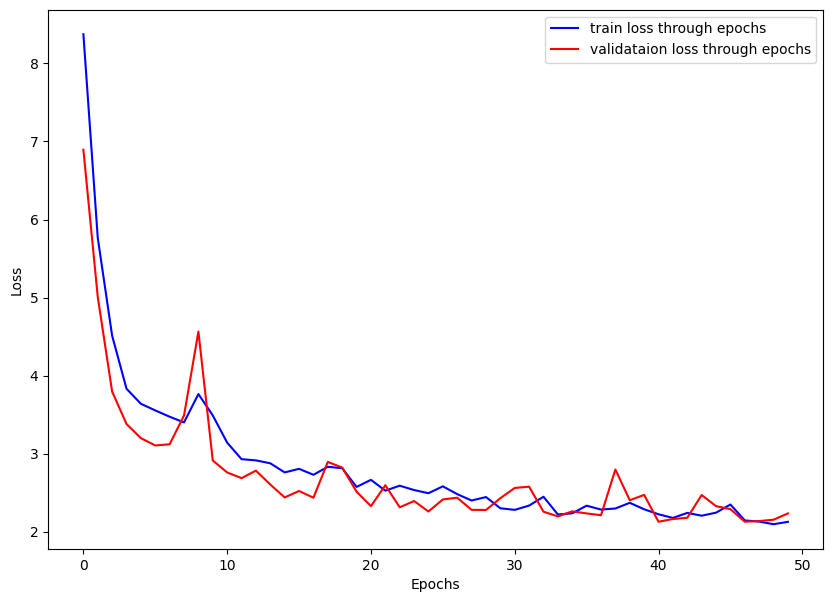

In [16]:
original_train_loss = facial_keypoint_pipeline.train_loss
original_validation_loss = facial_keypoint_pipeline.validation_loss

from matplotlib import pyplot as plt
import numpy as np

log_train_loss = [np.log(loss) for loss in original_train_loss]
log_validation_loss = [np.log(loss) for loss in original_validation_loss]
plt.figure(figsize=(10, 7))
plt.plot(log_train_loss, color='blue', label='train loss through epochs')
plt.plot(log_validation_loss, color='red', label='validataion loss through epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
        

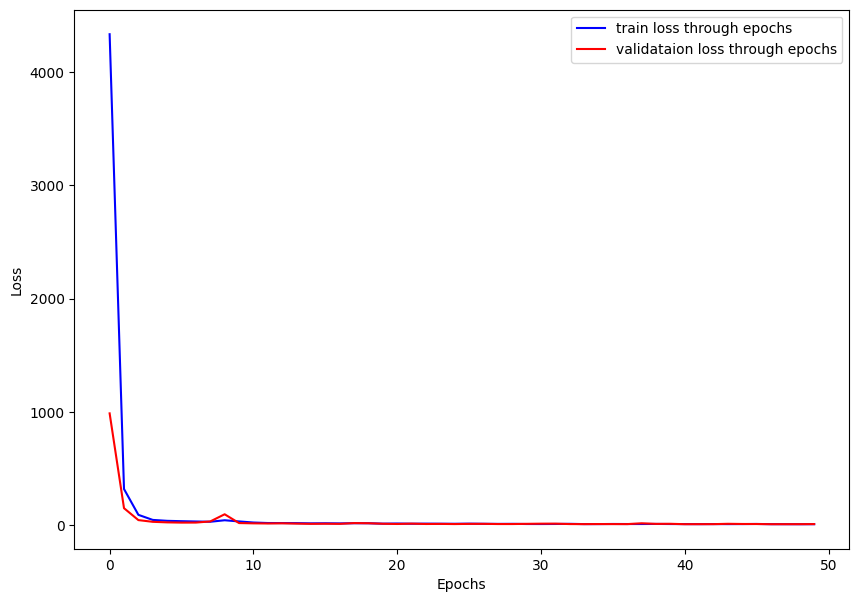

In [17]:
facial_keypoint_pipeline.generate_train_validation_loss_curves()

- Addition of batch_normalization is very helpful in improving performance, and before this -> the network had high values for both train and validation loss.
Initial high values of loss are from random initialization of weights and can be ignores. the above model cannot handle missing values. We are currently doing a ffil on these values.

- The next step would be to compare the above with a ResNet because of its ability to handle missing values in target keypoints.

- We also compare the above with OpenCV based cascade classifiers and feature engineering

In [8]:
facial_keypoint_pipeline.best_model

FacialKeypointVCNN(
  (conv2d1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2d1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d1): BatchNorm2d(32, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (conv2d2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2d2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d2): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (conv2d3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2d3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d3): BatchNorm2d(96, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear1): LazyLinear(in_features=0, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=30, bias=True)
)

#### Generate Predictions

In [9]:
fkd_test = FacialKeypointDataset(
    dataset_name="faces", 
    data_type = "csv",
    data_file=r"data/facial-keypoints-detection/test.csv",
    resize_size=96,
    is_test=True

)

In [10]:
import torch
import numpy as np

In [11]:
test_dataloader = facial_keypoint_pipeline.generate_test_dataloader_from_dataset(fkd_test)

In [12]:
test_dataloader[0].shape

torch.Size([250, 96, 96, 1])

In [14]:
predictions = facial_keypoint_pipeline.get_predictions(test_dataloader)

In [15]:
len(predictions)

1783

In [16]:
from matplotlib import pyplot as plt
def visualize_test_data(image_data, predictions, n_cols=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(20,12))
  
    for row in range(n_cols):
        sample_idx = np.random.choice(len(image_data))
        img = image_data[sample_idx]["image"].reshape(96,96)
        predicted = predictions[sample_idx]

        predicted = np.vstack(np.split(predicted, 15)).T
        axes[row].imshow(img, cmap='gray')
        axes[row].plot(predicted[0], predicted[1], 'o', color='green', label='predicted')
        axes[row].legend()


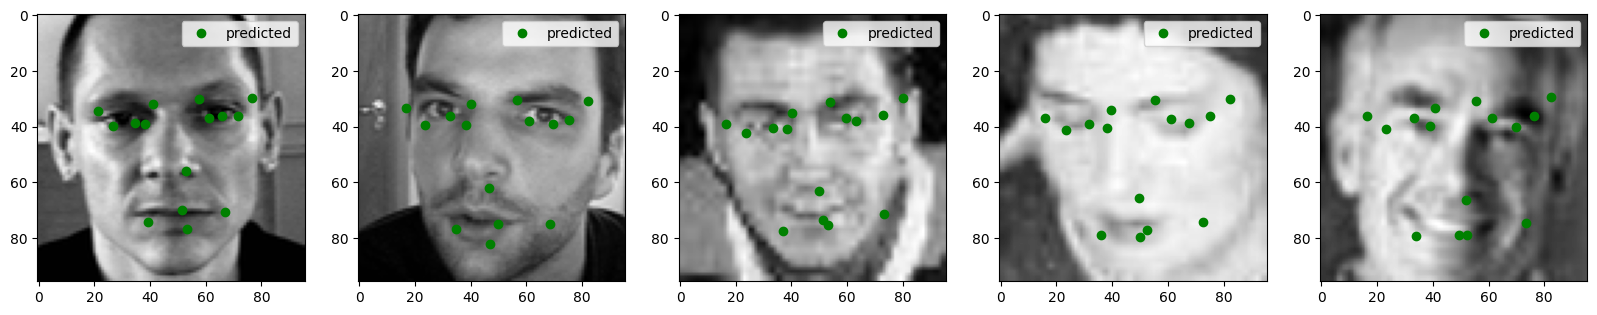

In [17]:
visualize_test_data(image_data=fkd_test, predictions=predictions)

The model doesn't work very well on faces that are turned or not looking forward. However, still good enough for the first submission

In [27]:
import pandas as pd
id_lookup = pd.read_csv("c:\\users\\sankr\\documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoints-detection\\IdLookupTable.csv")
id_lookup_features = list(id_lookup['FeatureName'])
id_lookup_image = list(id_lookup['ImageId'])

for i in range(len(id_lookup_features)):
    id_lookup_features[i] = fkd.dataset.image_labels.columns.tolist().index(id_lookup_features[i])

location = []
for i in range(len(id_lookup_features)):
    location.append(predictions[id_lookup_image[i]-1][id_lookup_features[i]])

In [33]:
id_lookup['FeatureName']= location
submission = id_lookup[['RowId', 'FeatureName']]

In [37]:
submission.rename(columns={"FeatureName": "Location"}, inplace=True)


In [38]:
submissions_folder = "c:\\users\\sankr\\documents\\projects\\git_work\\experiments_cv_nlp\\data\\facial-keypoints-detection\\submissions"
import os

os.makedirs(submissions_folder, exist_ok=True)
submission_path = os.path.join(submissions_folder, "facial_keypoint_detections.csv")
submission.to_csv(submission_path, index=False)

The model fails to perform when the face is titled or turned. But still seems good enough for the first submission

In [39]:
from kaggle_utils.kaggle_cli_wrapper import KaggleScoringsApi

In [40]:
kaggle_scoring_api = KaggleScoringsApi(competition_name="facial-keypoints-detection")

In [42]:
kaggle_scoring_api.submit_solution(submissions_file=submission_path, description="facial_keypoint_vanilla_cnn")

In [43]:
kaggle_scoring_api.get_top_scores()

In [45]:
!kaggle competitions submissions -c "facial-keypoints-detection"

fileName                        date                 description                  status    publicScore  privateScore  
------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
facial_keypoint_detections.csv  2023-01-25 23:02:06  facial_keypoint_vanilla_cnn  complete  3.65729      3.46076       
facial_keypoint_detections.csv  2023-01-25 22:56:56  facial_keypoint_vanilla_cnn  error                                
facial_keypoint_detections.csv  2023-01-25 22:49:20  facial_keypoint_vanilla_cnn  error                                
